# Google Maps Restaurant Reviews Data Cleaning

This notebook contains data cleaning operations for the restaurant reviews dataset.

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pandas'

## 1. Load and Inspect Data

In [ ]:
# Load the dataset
df = pd.read_csv('data/reviews.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (1100, 6)

Column Names:
['business_name', 'author_name', 'text', 'photo', 'rating', 'rating_category']

First few rows:


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


In [ ]:
# Data types and missing values
print("Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df)) * 100)

Data Types:
business_name      object
author_name        object
text               object
photo              object
rating              int64
rating_category    object
dtype: object

Missing Values:
business_name      0
author_name        0
text               0
photo              0
rating             0
rating_category    0
dtype: int64

Missing Values Percentage:
business_name      0.0
author_name        0.0
text               0.0
photo              0.0
rating             0.0
rating_category    0.0
dtype: float64


## 2. Data Quality Assessment

In [ ]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

# Check for duplicate reviews by same author for same business
duplicate_reviews = df.duplicated(subset=['business_name', 'author_name'], keep=False)
print("Potential duplicate reviews by same author:", duplicate_reviews.sum())

if duplicate_reviews.sum() > 0:
    print("\nDuplicate review examples:")
    print(df[duplicate_reviews][['business_name', 'author_name', 'rating']].head(10))

Duplicate rows: 0
Potential duplicate reviews by same author: 0


In [ ]:
# Validate rating values
print("Unique rating values:", sorted(df['rating'].unique()))
print("Rating value counts:")
print(df['rating'].value_counts().sort_index())

# Check for invalid ratings (should be 1-5)
invalid_ratings = df[(df['rating'] < 1) | (df['rating'] > 5)]
print(f"\nInvalid ratings (not 1-5): {len(invalid_ratings)}")

Unique rating values: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Rating value counts:
rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

Invalid ratings (not 1-5): 0


In [ ]:
# Validate rating categories
print("Unique rating categories:")
print(df['rating_category'].value_counts())

# Check for any unexpected categories
expected_categories = ['taste', 'indoor_atmosphere', 'outdoor_atmosphere', 'menu']
unexpected_categories = df[~df['rating_category'].isin(expected_categories)]
print(f"\nUnexpected rating categories: {len(unexpected_categories)}")
if len(unexpected_categories) > 0:
    print(unexpected_categories['rating_category'].unique())

Unique rating categories:
rating_category
taste                 330
indoor_atmosphere     288
outdoor_atmosphere    286
menu                  196
Name: count, dtype: int64

Unexpected rating categories: 0


## 3. Text Data Cleaning

In [ ]:
# Clean business names
print("Unique businesses before cleaning:", df['business_name'].nunique())
print("Sample business names:")
print(df['business_name'].value_counts().head(10))

# Function to clean business names
def clean_business_name(name):
    if pd.isna(name):
        return name
    # Remove extra whitespace
    name = ' '.join(name.split())
    # Standardize common variations
    name = name.replace('&', 'and')
    return name.strip()

df['business_name_cleaned'] = df['business_name'].apply(clean_business_name)
print(f"\nUnique businesses after cleaning: {df['business_name_cleaned'].nunique()}")

Unique businesses before cleaning: 100
Sample business names:
business_name
Haci'nin Yeri - Yigit Lokantasi    11
Pizza Fellas                       11
Cafe Inn                           11
Riviera                            11
Sakip Usta Gaziantep               11
Imam Cagdas                        11
Gold Semaver                       11
Fethiye Dondurmacisi               11
My Friends Burger                  11
Mcdonalds Fethiye                  11
Name: count, dtype: int64

Unique businesses after cleaning: 100


In [ ]:
# Clean author names
print("Sample author names:")
print(df['author_name'].value_counts().head(10))

# Function to clean author names
def clean_author_name(name):
    if pd.isna(name):
        return name
    # Remove extra whitespace
    name = ' '.join(name.split())
    # Capitalize properly
    name = name.title()
    return name.strip()

df['author_name_cleaned'] = df['author_name'].apply(clean_author_name)

Sample author names:
author_name
Ece Oztunc          3
Mustafa Ay          3
Nihat Karabiber     3
Saliha Senyildiz    3
Mevlut Sahin        2
Halit Kerim         2
Gun Oksay           2
Enes Ozturk         2
Nafican Tatlici     2
Selcuk Uras         2
Name: count, dtype: int64


In [ ]:
# Clean review text
def clean_review_text(text):
    if pd.isna(text):
        return text
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove multiple periods/ellipses at the end
    text = re.sub(r'\.+$', '.', text)
    
    # Fix common punctuation issues
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)  # Remove space before punctuation
    text = re.sub(r'([,.!?;:])([a-zA-Z])', r'\1 \2', text)  # Add space after punctuation
    
    return text.strip()

df['text_cleaned'] = df['text'].apply(clean_review_text)

# Check text length statistics
df['text_length'] = df['text_cleaned'].str.len()
print("Text length statistics:")
print(df['text_length'].describe())

Text length statistics:
count    1100.000000
mean      110.797273
std        69.134845
min         5.000000
25%        62.000000
50%       104.000000
75%       147.000000
max       913.000000
Name: text_length, dtype: float64


## 4. Photo Path Validation

In [ ]:
# Validate photo paths
print("Sample photo paths:")
print(df['photo'].head(10).tolist())

# Check for missing photo paths
missing_photos = df['photo'].isnull().sum()
print(f"\nMissing photo paths: {missing_photos}")

# Validate photo path format
def validate_photo_path(path):
    if pd.isna(path):
        return False
    # Check if path follows expected format: dataset/category/filename.png
    pattern = r'^dataset/(taste|indoor_atmosphere|outdoor_atmosphere|menu)/[^/]+\.png$'
    return bool(re.match(pattern, path))

df['valid_photo_path'] = df['photo'].apply(validate_photo_path)
invalid_photo_paths = (~df['valid_photo_path']).sum()
print(f"Invalid photo paths: {invalid_photo_paths}")

if invalid_photo_paths > 0:
    print("\nExamples of invalid photo paths:")
    print(df[~df['valid_photo_path']]['photo'].head(5).tolist())

Sample photo paths:
['dataset/taste/hacinin_yeri_gulsum_akar.png', 'dataset/menu/hacinin_yeri_oguzhan_cetin.png', 'dataset/outdoor_atmosphere/hacinin_yeri_yasin_kuyu.png', 'dataset/indoor_atmosphere/hacinin_yeri_orhan_kapu.png', 'dataset/menu/hacinin_yeri_ozgur_sati.png', 'dataset/indoor_atmosphere/hacinin_yeri_arda_karaca.png', 'dataset/taste/hacinin_yeri_irem_eren.png', 'dataset/taste/hacinin_yeri_nadia_salim.png', 'dataset/outdoor_atmosphere/hacinin_yeri_mehmet_eser.png', 'dataset/indoor_atmosphere/hacinin_yeri_celal_ozer.png']

Missing photo paths: 0
Invalid photo paths: 0


## 5. Data Consistency Checks

In [ ]:
# Check if photo path category matches rating_category
def extract_photo_category(path):
    if pd.isna(path):
        return None
    match = re.search(r'dataset/([^/]+)/', path)
    return match.group(1) if match else None

df['photo_category'] = df['photo'].apply(extract_photo_category)

# Check for mismatches
category_mismatch = df['photo_category'] != df['rating_category']
mismatches = df[category_mismatch & df['photo_category'].notna()]
print(f"Photo category mismatches: {len(mismatches)}")

if len(mismatches) > 0:
    print("\nExample mismatches:")
    print(mismatches[['business_name', 'rating_category', 'photo_category']].head())

Photo category mismatches: 0


## 6. Outlier Detection

In [ ]:
# Detect extremely short or long reviews
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, alpha=0.7)
plt.xlabel('Review Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths')

plt.subplot(1, 2, 2)
plt.boxplot(df['text_length'])
plt.ylabel('Review Length (characters)')
plt.title('Review Length Boxplot')

plt.tight_layout()
plt.show()

# Identify outliers
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"\nText length outliers: {len(outliers)}")
print(f"Very short reviews (<50 chars): {(df['text_length'] < 10).sum()}")
print(f"Very long reviews (>1000 chars): {(df['text_length'] > 1000).sum()}")

NameError: name 'plt' is not defined

## 7. Create Clean Dataset

In [ ]:
# Create clean dataset
df_clean = df.copy()

# Remove exact duplicates
df_clean = df_clean.drop_duplicates()
print(f"Removed {len(df) - len(df_clean)} duplicate rows")

# Remove rows with invalid ratings
before_count = len(df_clean)
df_clean = df_clean[(df_clean['rating'] >= 1) & (df_clean['rating'] <= 5)]
print(f"Removed {before_count - len(df_clean)} rows with invalid ratings")

# Remove rows with empty text
before_count = len(df_clean)
df_clean = df_clean[df_clean['text_cleaned'].notna() & (df_clean['text_cleaned'].str.strip() != '')]
print(f"Removed {before_count - len(df_clean)} rows with empty review text")

# Remove extremely short reviews (less than 10 characters)
before_count = len(df_clean)
df_clean = df_clean[df_clean['text_length'] >= 10]
print(f"Removed {before_count - len(df_clean)} extremely short reviews")

print(f"\nFinal clean dataset size: {len(df_clean)} rows")

Removed 0 duplicate rows
Removed 0 rows with invalid ratings
Removed 0 rows with empty review text
Removed 13 extremely short reviews

Final clean dataset size: 1087 rows


In [ ]:
# Select final columns for clean dataset
final_columns = [
    'business_name_cleaned',
    'author_name_cleaned', 
    'text_cleaned',
    'photo',
    'rating',
    'rating_category',
    'text_length'
]

df_final = df_clean[final_columns].copy()

# Rename columns
df_final.columns = [
    'business_name',
    'author_name',
    'text',
    'photo',
    'rating',
    'rating_category',
    'text_length'
]

print("Final dataset shape:", df_final.shape)
print("\nFinal dataset info:")
print(df_final.info())

Final dataset shape: (1087, 7)

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1087 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1087 non-null   object
 1   author_name      1087 non-null   object
 2   text             1087 non-null   object
 3   photo            1087 non-null   object
 4   rating           1087 non-null   int64 
 5   rating_category  1087 non-null   object
 6   text_length      1087 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 67.9+ KB
None


## 8. Data Summary and Export

In [ ]:
# Generate summary statistics
print("=== CLEAN DATASET SUMMARY ===")
print(f"Total reviews: {len(df_final)}")
print(f"Unique businesses: {df_final['business_name'].nunique()}")
print(f"Unique reviewers: {df_final['author_name'].nunique()}")
print(f"Rating distribution:")
print(df_final['rating'].value_counts().sort_index())
print(f"\nRating category distribution:")
print(df_final['rating_category'].value_counts())
print(f"\nAverage review length: {df_final['text_length'].mean():.1f} characters")

=== CLEAN DATASET SUMMARY ===
Total reviews: 1087
Unique businesses: 100
Unique reviewers: 1061
Rating distribution:
rating
1     80
2     72
3    170
4    311
5    454
Name: count, dtype: int64

Rating category distribution:
rating_category
taste                 326
indoor_atmosphere     287
outdoor_atmosphere    280
menu                  194
Name: count, dtype: int64

Average review length: 112.0 characters


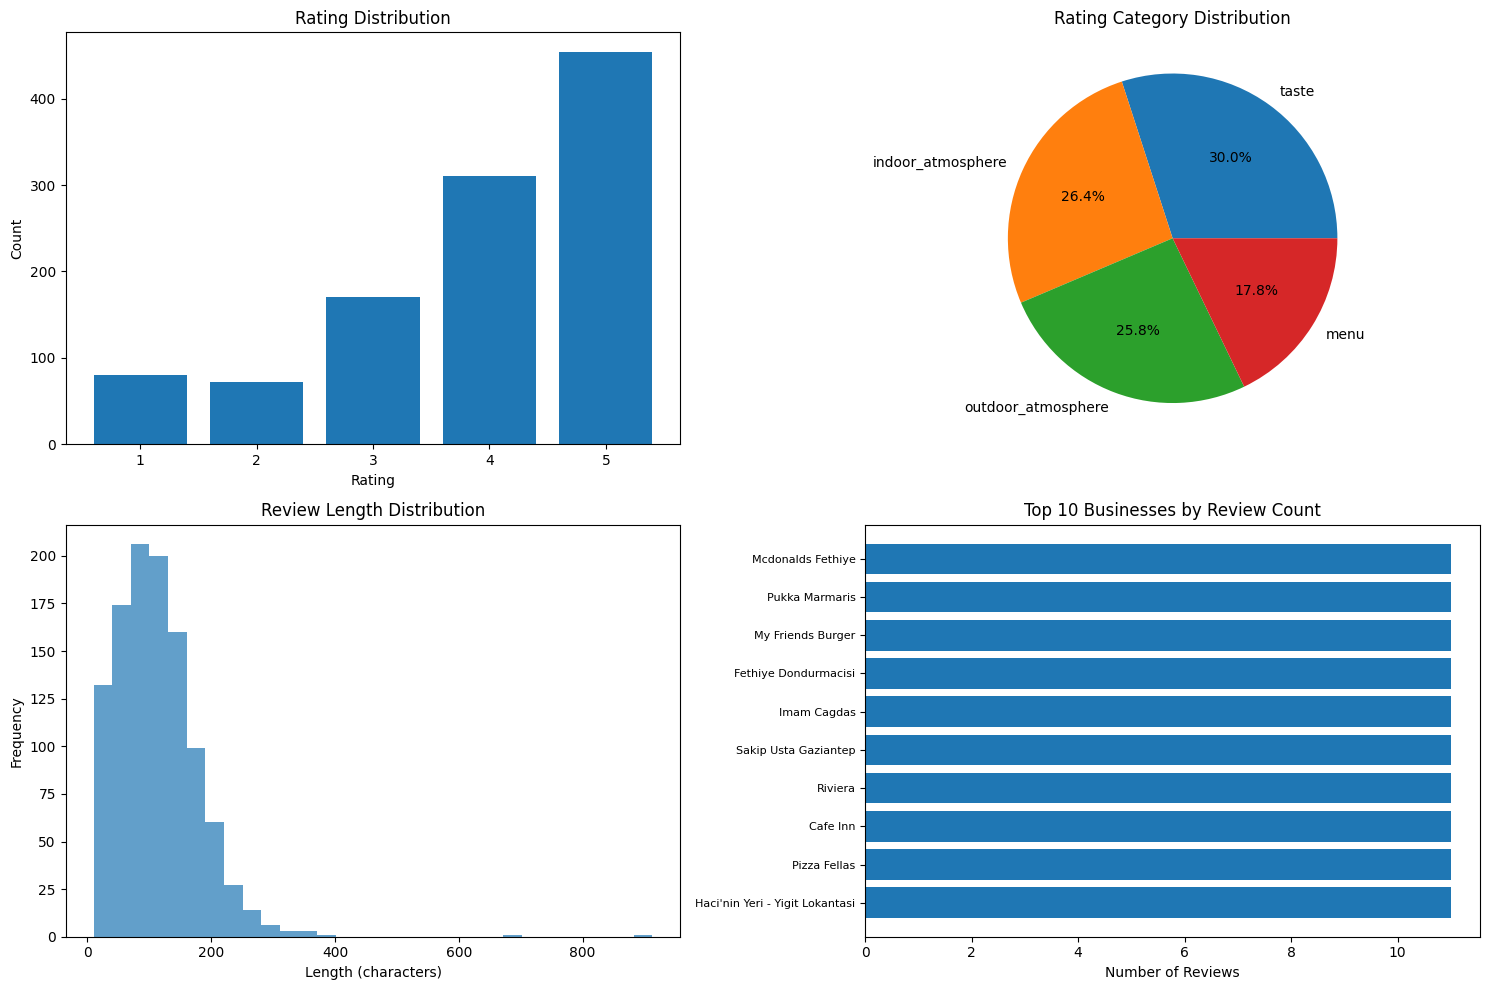

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].bar(df_final['rating'].value_counts().sort_index().index, 
               df_final['rating'].value_counts().sort_index().values)
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Rating category distribution
category_counts = df_final['rating_category'].value_counts()
axes[0, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('Rating Category Distribution')

# Text length distribution
axes[1, 0].hist(df_final['text_length'], bins=30, alpha=0.7)
axes[1, 0].set_title('Review Length Distribution')
axes[1, 0].set_xlabel('Length (characters)')
axes[1, 0].set_ylabel('Frequency')

# Top businesses by review count
top_businesses = df_final['business_name'].value_counts().head(10)
axes[1, 1].barh(range(len(top_businesses)), top_businesses.values)
axes[1, 1].set_yticks(range(len(top_businesses)))
axes[1, 1].set_yticklabels(top_businesses.index, fontsize=8)
axes[1, 1].set_title('Top 10 Businesses by Review Count')
axes[1, 1].set_xlabel('Number of Reviews')

plt.tight_layout()
plt.show()

In [ ]:
# Export clean dataset
df_final.to_csv('reviews_cleaned.csv', index=False)
print("Clean dataset exported to 'reviews_cleaned.csv'")

# Export data quality report
quality_report = {
    'original_rows': len(df),
    'final_rows': len(df_final),
    'rows_removed': len(df) - len(df_final),
    'removal_percentage': ((len(df) - len(df_final)) / len(df)) * 100,
    'unique_businesses': df_final['business_name'].nunique(),
    'unique_reviewers': df_final['author_name'].nunique(),
    'avg_rating': df_final['rating'].mean(),
    'avg_text_length': df_final['text_length'].mean()
}

print("\nDATA QUALITY REPORT")
for key, value in quality_report.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

Clean dataset exported to 'reviews_cleaned.csv'

DATA QUALITY REPORT
original_rows: 1100
final_rows: 1087
rows_removed: 13
removal_percentage: 1.18
unique_businesses: 100
unique_reviewers: 1061
avg_rating: 3.91
avg_text_length: 112.04
